# Imports and data generation

In [1]:
import os

In [2]:
#!/usr/bin/env python
# coding: utf-8

import argparse
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from experiments_utils import (
    get_vals,
    compute_predictions,
)
from scvi.dataset import GeneExpressionDataset
from scvi.utils import make_dir_if_necessary
from scvi_utils import (
    filename_formatter,
)

N_CELLS_QUERY = 150
FOLDER_NAME = "./runs/symsim_da"
DELTA = 0.4
SEED = 1
print("SEED:", SEED)
N_CELLS_REF = 500
N_OTHERS = 1000
OFFSET = 1e-10
# OFFSET = 0.0

N_EPOCHS = 1000
N_PICKS = 1
N_SAMPLES = 10000

print("USING OFFSET = {}".format(OFFSET))

RECONSTRUCTION_LOSS = "nb"
N_PICKS = 2
ADVANCED_PROPS = True
N_SAMPLES = 5000
# N_EPOCHS = 500
N_LATENT = 50
PIN_MEMORY = False
USE_BATCH_NORM = False
PATH_TO_SCRIPTS = "MYPATHTOSCRIPTS"
DIR_PATH = "{FOLDER_NAME}/symsim_bimod_{N_CELLS_QUERY}_{N_CELLS_REF}_{OFFSET}_{DELTA}_{N_OTHERS}_{SEED}".format(
    FOLDER_NAME=FOLDER_NAME,
    N_CELLS_QUERY=N_CELLS_QUERY,
    N_CELLS_REF=N_CELLS_REF,
    OFFSET=OFFSET,
    DELTA=DELTA,
    N_OTHERS=N_OTHERS,
    SEED=SEED,
)


Q0 = 1e-1
# np.random.seed(SEED)
make_dir_if_necessary(DIR_PATH)
print(os.listdir(DIR_PATH))

#####################################################
#####################################################
# # Generate Datase
# dataset
# gene_means
# n_genes
# n_examples_ct
# label_a
# label_b
# lfc_gt
# is_significant_de
symsim_data_path = (
    "./data/symsim_nevf30.n_de_evf_18.sigma_0.rep_1/DE"
)


batch_info = (
    pd.read_csv(os.path.join(symsim_data_path, "DE_med.batchid.csv"), index_col=0) - 1
)
##################
### One BATCH
##################
x_obs_all = pd.read_csv(
    os.path.join(symsim_data_path, "DE_med.obsv.3.csv"), index_col=0
).T[(batch_info == 0).values]
metadata = pd.read_csv(
    os.path.join(symsim_data_path, "DE_med.cell_meta.csv"), index_col=0
)[(batch_info == 0).values]
batch_info = batch_info[(batch_info == 0).values]
#####################


x_obs = x_obs_all

# OLD
select_gene = np.arange(x_obs_all.values.shape[1])
# non_null_genes = x_obs_all.sum(0) > 0
# _lfc_info = pd.read_csv(
#     os.path.join(symsim_data_path, "med_theoreticalFC.csv"), index_col=0
# )
# bimod_select = (_lfc_info["23"].abs() <= 0.2) | (_lfc_info["23"].abs() >= 1.5)

# NEW
label_a = 1
label_b = 2

lfc_info = pd.read_csv(
    os.path.join(symsim_data_path, "med_theoreticalFC.csv"), index_col=0
)
lfc_gt =lfc_info["23"]

select_gene = np.arange(x_obs_all.values.shape[1])
non_null_genes = x_obs_all.sum(0) > 0
bimod_select = (np.abs(lfc_gt) <= 0.2) | (np.abs(lfc_gt) >= 1.0)

select_gene = non_null_genes * bimod_select

select_gene_ = np.isin(np.arange(len(select_gene)), np.where(select_gene.values)[0][:1000])
select_gene = select_gene_
# x_obs_all = x_obs_all.loc[:, non_null_genes]
x_obs = x_obs_all.loc[:, select_gene]

true_ = pd.read_csv(
    os.path.join(symsim_data_path, "DE_med.true.csv"), index_col=0
).T.loc[:, select_gene]
lfc_info = pd.read_csv(
    os.path.join(symsim_data_path, "med_theoreticalFC.csv"), index_col=0
).loc[select_gene, :]
# lfc_info[d_key].values
print("Original data distrib: ", metadata["pop"].groupby(metadata["pop"]).size())

# Data only
# n_examples_ct = np.array([2000, 2000, N_CELLS_QUERY, 2000, 2000])


# n_examples_ct = np.array([N_OTHERS, N_CELLS_REF, N_CELLS_QUERY, N_OTHERS, N_OTHERS])
# n_examples_ct = np.array([1007, 200, 200, 987, 999])


/data/yosef2/users/pierreboyeau/conda/envs/DE/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.


SEED: 1
USING OFFSET = 1e-10
[]


/data/yosef2/users/pierreboyeau/conda/envs/DE/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead


Original data distrib:  pop
1    1007
2    1014
3    1030
4     987
5     999
Name: pop, dtype: int64


In [3]:
metadata["pop"].value_counts().sort_index()

1    1007
2    1014
3    1030
4     987
5     999
Name: pop, dtype: int64

In [4]:
# n_examples_ct = np.array([2000, 200, 200, 2000, 2000])
n_examples_ct = np.array([1007, 500, 500, 987, 999])

In [5]:
lfc_info

,24,45,23,12
2,1.316535,0.382303,0.115329,-2.470163
3,0.044400,-0.329002,0.066018,1.336251
5,-0.339799,0.371144,-0.121430,-0.276009
6,-1.368418,-0.019002,-1.309445,0.657169
8,0.383400,-0.754900,0.163949,-0.522600
...,...,...,...,...
993,0.217702,-0.638069,0.163051,-0.211217
994,-0.352452,-0.080771,-0.142328,1.053311
995,-0.013069,0.078293,0.095807,-0.215238
996,-0.982282,0.027855,-1.147552,2.416447


In [6]:
os.listdir(symsim_data_path)

['DE_med.batchid.csv',
 'DE_med.cell_meta.csv',
 'DE_med.s_mat.csv',
 'med_theoreticalFC.csv',
 'DE_med.kon_mat.csv',
 'DE_med.koff_mat.csv',
 'med_n_evf.csv',
 'DE_med.obsv.3.csv',
 'DE_med.true.csv']

In [7]:
# lfc_info = pd.read_csv(
#     os.path.join(symsim_data_path, "med_theoreticalFC.csv"), index_col=0
# )

In [8]:
metadata = metadata.reset_index()

In [9]:
selected_indices = (
    metadata["pop"]
    .sample(frac=1.0, random_state=SEED)
    .groupby(metadata["pop"])
    .apply(lambda x: x.iloc[: n_examples_ct[x.name - 1]].index.values)
)
indices = np.concatenate(selected_indices.values)
print(selected_indices.apply(lambda x: len(x)))

X=x_obs.values[indices]
batch_indices=batch_info["x"].values[indices]
labels=metadata["pop"].values[indices]
cell_types=metadata["pop"].values[indices]
batch_all = batch_info["x"].values

pop
1    1007
2     500
3     500
4     987
5     999
Name: pop, dtype: int64


In [10]:
dataset = GeneExpressionDataset()
dataset.populate_from_data(
    X=X,
    batch_indices=batch_indices,
    labels=labels,
    cell_types=cell_types,
)

INFO:scvi.dataset.dataset:Remapping batch_indices to [0,N]
INFO:scvi.dataset.dataset:Remapping labels to [0,N]


In [11]:
dataset.X.shape

(3993, 396)

# Synthetically creating broader DA 

## Generating pools

In [12]:
# Generating gene pools
all_indices = np.arange(len(metadata["pop"]))
not_selected = ~np.isin(all_indices, indices)

original_labels = (metadata["pop"] - 1).values

all_a = original_labels == 1
all_b = original_labels == 2
print(all_a.sum(), all_b.sum())

pool_a_ix = all_a & not_selected
pool_b_ix = all_b & not_selected

pool_a = x_obs.values[pool_a_ix][:500] # [:787]
pool_b = x_obs.values[pool_b_ix][:500] # [:787]
print(pool_a.shape, pool_b.shape)

y_all = dataset.labels.squeeze()
idx_a = np.where(y_all == 1)[0]
idx_b = np.where(y_all == 2)[0]

1014 1030
(500, 396) (500, 396)


In [13]:
label_a = 1
label_b = 2
n_genes = dataset.nb_genes

d_key = "{}{}".format(label_a + 1, label_b + 1)
print(d_key)

is_significant_de = (lfc_info[d_key].abs() >= DELTA).values
lfc_gt = lfc_info[d_key].values

print("label_a: {} examples".format(n_examples_ct[label_a]))
print("label_b: {} examples".format(n_examples_ct[label_b]))

23
label_a: 500 examples
label_b: 500 examples


## Changing Data

In [14]:
def change_data(counts, idx_a, idx_b, gene,  mode, pool_a, pool_b):
    """
    Assumes the gene already is DE to go forward
    """
    pool_a_gene = pool_a[:, gene]
    pool_b_gene = pool_b[:, gene]
    pool_mix_gene = (0.5 * (pool_a_gene + pool_b_gene)).astype(int)
    c = np.random.uniform(0.1, 0.2)
    na, nb = len(idx_a), len(idx_b)
    
    if mode == "EP":
        na_toa = int(c* len(idx_a))
        na_tob = int(c * len(idx_b))
        nb_toa = na - na_toa
        nb_tob = nb - na_tob
        
        pool_a_gene_toa = np.random.choice(pool_a_gene, na_toa)
        pool_a_gene_tob = np.random.choice(pool_a_gene, na_tob)
        pool_b_gene_toa = np.random.choice(pool_b_gene, nb_toa)
        pool_b_gene_tob = np.random.choice(pool_b_gene, nb_tob)
        
        new_a = np.concatenate([pool_a_gene_toa, pool_b_gene_toa])
        new_b = np.concatenate([pool_a_gene_tob, pool_b_gene_tob])
    elif mode == "DP":
        nb_toa = int(c* len(idx_a))
        na_tob = int(c * len(idx_b))
        na_toa = na - nb_toa
        nb_tob = nb - na_tob
        
        pool_a_gene_toa = np.random.choice(pool_a_gene, na_toa)
        pool_a_gene_tob = np.random.choice(pool_a_gene, na_tob)
        pool_b_gene_toa = np.random.choice(pool_b_gene, nb_toa)
        pool_b_gene_tob = np.random.choice(pool_b_gene, nb_tob)
        
        new_a = np.concatenate([pool_a_gene_toa, pool_b_gene_toa])
        new_b = np.concatenate([pool_a_gene_tob, pool_b_gene_tob])
    elif mode == "DM":
        nb_toa = 0
        na_tob = int(c * len(idx_b))
        na_toa = na - nb_toa
        nb_tob = nb - na_tob
        
        pool_a_gene_toa = np.random.choice(pool_a_gene, na_toa)
        pool_a_gene_tob = np.random.choice(pool_a_gene, na_tob)
        pool_b_gene_toa = np.random.choice(pool_b_gene, nb_toa)
        pool_b_gene_tob = np.random.choice(pool_b_gene, nb_tob)
        
        new_a = np.concatenate([pool_a_gene_toa, pool_b_gene_toa])
        new_b = np.concatenate([pool_a_gene_tob, pool_b_gene_tob])
    elif mode == "DB":
        na_toa = int(0.5 * len(idx_b))
        nb_toa = na - na_toa
        pool_a_gene_toa = np.random.choice(pool_a_gene, na_toa)
        pool_b_gene_toa = np.random.choice(pool_b_gene, nb_toa)
        new_a = np.concatenate([pool_a_gene_toa, pool_b_gene_toa])

        new_b = np.random.choice(pool_mix_gene, len(idx_b))
    counts[idx_a, gene] = new_a
    counts[idx_b, gene] = new_b

In [15]:
np.random.seed(0)

In [16]:
de_mapper = np.array(["EE", "DE"])
de_original_status = de_mapper[is_significant_de.astype(int)]


In [17]:
new_counts = dataset.X.copy()

In [19]:
fn_kwargs = {
    "counts": new_counts,
    # "counts": log_cpm,
    "idx_a": idx_a, 
    "idx_b": idx_b, 
    "pool_a": pool_a, 
    "pool_b": pool_b
}

In [20]:
differential_analysis_gt = []
for gene_id, gene_is_de in enumerate(de_original_status):
    mode = "EE"
    if gene_is_de == "DE":
        randm = np.random.random()
        if randm <= .1*1:
            mode = "EP"
        elif randm <= .1*2:
            mode = "DP"
        elif randm <= .1*3:
            mode = "DM"
        elif randm <= .1*4:
            mode = "DB"
        else:
            mode =  "DE"
    if mode in ["EP", "DP", "DM", "DB"]:
        change_data(gene=gene_id, mode=mode, **fn_kwargs)
    differential_analysis_gt.append(mode)
differential_analysis_gt = np.array(differential_analysis_gt)

In [21]:
pd.Series(differential_analysis_gt).value_counts()

EE    269
DE     78
DP     13
DM     13
EP     12
DB     11
dtype: int64

In [23]:
%matplotlib inline

(array([269.,   0.,  78.,   0.,  11.,   0.,  13.,   0.,  13.,  12.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

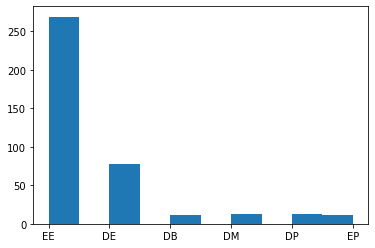

In [24]:
plt.hist(differential_analysis_gt)

### Visualization

In [25]:
# import plotnine as p9

# # seri = pd.DataFrame(
# #     dict(
# #         max_v=dataset.X[np.concatenate([idx_a, idx_b])].max(0),
# #         status=differential_analysis_gt,
# #     )
# # ).assign(max_val=lambda x: x.max_v.clip(upper=50))

# # (
# #     p9.ggplot(seri, p9.aes(x="max_val"))
# #     + p9.geom_histogram()
# #     + p9.facet_wrap("status")
# # )

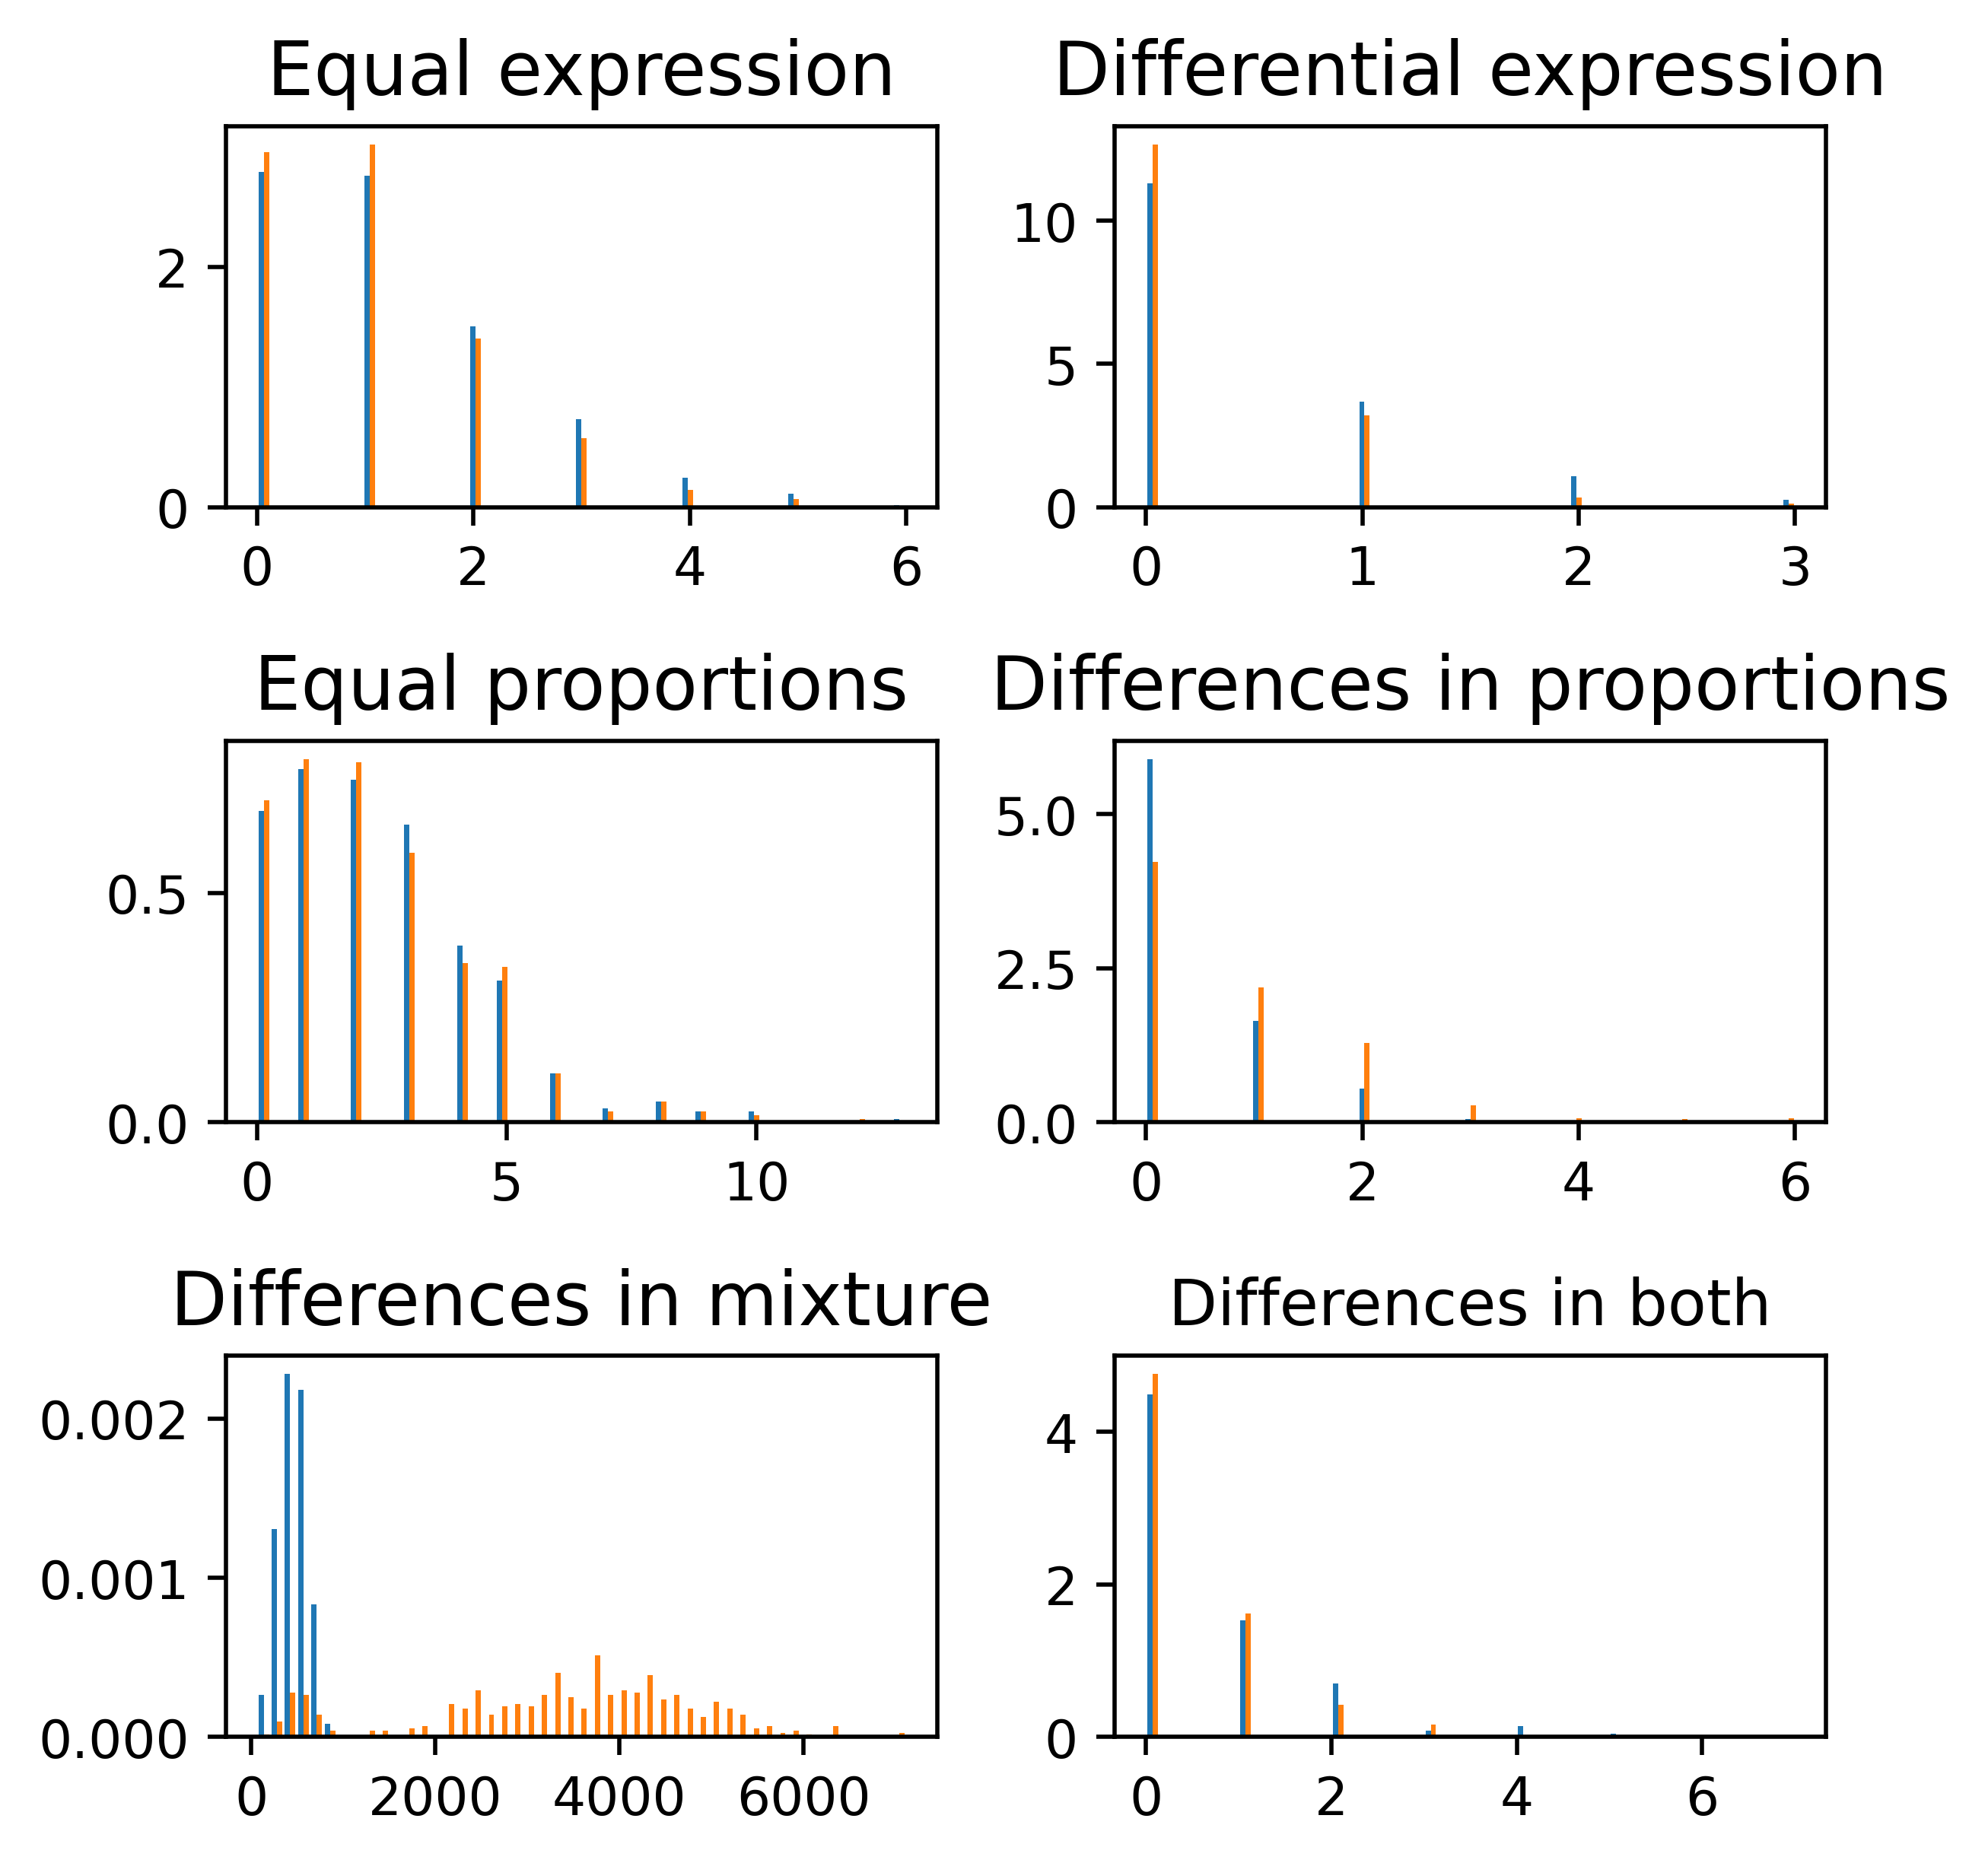

In [26]:
ab = np.concatenate([idx_a, idx_b])

# data_vis = np.log1p(new_counts)
data_vis = new_counts

def plot_gene_dist(gene_idx):
    rg = data_vis[ab, gene_idx].min(), data_vis[ab, gene_idx].max() 
    bins = np.linspace(*rg, num=50)
#     plt.hist(new_counts[idx_a, gene_idx], bins=bins, density=True)
#     plt.hist(new_counts[idx_b, gene_idx], bins=bins, density=True)
    plt.hist(
        [data_vis[idx_a, gene_idx], data_vis[idx_b, gene_idx]], 
        bins=bins, 
        density=True
    )
    
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=500, figsize=(5, 5))
FS = 14
_id = 5
plt.sca(axes[0, 0])
plt.title("Equal expression", fontsize=FS)
gene_idx = np.where(differential_analysis_gt == "EE")[0][_id]
plot_gene_dist(gene_idx)

plt.sca(axes[0, 1])
plt.title("Differential expression", fontsize=FS)
gene_idx = np.where(differential_analysis_gt == "DE")[0][_id]
plot_gene_dist(gene_idx)


plt.sca(axes[1, 0])
plt.title("Equal proportions", fontsize=FS)
gene_idx = np.where(differential_analysis_gt == "EP")[0][_id]
plot_gene_dist(gene_idx)

plt.sca(axes[1, 1])
plt.title("Differences in proportions", fontsize=FS)
gene_idx = np.where(differential_analysis_gt == "DP")[0][_id]
plot_gene_dist(gene_idx)

plt.sca(axes[2, 0])
plt.title("Differences in mixture", fontsize=FS)
gene_idx = np.where(differential_analysis_gt == "DM")[0][_id]
plot_gene_dist(gene_idx)

plt.sca(axes[2, 1])
plt.title("Differences in both")
gene_idx = np.where(differential_analysis_gt == "DB")[0][_id]
plot_gene_dist(gene_idx)

plt.tight_layout()

In [27]:
# final_counts = (libs / 1e6 * new_counts)
# final_counts

In [28]:
# (dataset.X - final_counts).max()

In [29]:
# new_counts = final_counts

# Final data generation

In [30]:
dataset = GeneExpressionDataset()
dataset.populate_from_data(
    X=new_counts,
    batch_indices=batch_info["x"].values[indices],
    labels=metadata["pop"].values[indices],
    cell_types=metadata["pop"].values[indices],
)
print(dataset.X.shape)
print(np.unique(dataset.labels, return_counts=True))


n_examples = len(dataset)
TEST_INDICES = np.arange(len(dataset))
n_genes = dataset.nb_genes
x_test, y_test = dataset.X[TEST_INDICES, :], dataset.labels[TEST_INDICES, :].squeeze()
batch_test = dataset.batch_indices[TEST_INDICES, :].squeeze()
x_test[:, -1] = 1.0 + x_test[:, -1]
y_all = dataset.labels.squeeze()
data_path = os.path.join(DIR_PATH, "data.npy")
labels_path = os.path.join(DIR_PATH, "labels.npy")
batches_path = os.path.join(DIR_PATH, "batch_indices.npy")
np.save(data_path, x_test.squeeze().astype(int))
np.savetxt(labels_path, y_test.squeeze())
np.savetxt(batches_path, batch_test.squeeze())

# ## Params
label_a = 1
label_b = 2
n_genes = dataset.nb_genes

d_key = "{}{}".format(label_a + 1, label_b + 1)
print(d_key)

is_significant_de = (lfc_info[d_key].abs() >= DELTA).values
lfc_gt = lfc_info[d_key].values

print("label_a: {} examples".format(n_examples_ct[label_a]))
print("label_b: {} examples".format(n_examples_ct[label_b]))


idx_a = np.where(y_all == label_a)[0]
gene_means = np.log10(dataset.X[idx_a].mean(0))

sset_genes = (np.abs(lfc_gt) <= 0.1) | (np.abs(lfc_gt) >= 0.8 + 0.1)
where_de_ee = np.arange(n_genes)
where_ = np.arange(n_genes)

INFO:scvi.dataset.dataset:Remapping batch_indices to [0,N]
INFO:scvi.dataset.dataset:Remapping labels to [0,N]


(3993, 396)
(array([0, 1, 2, 3, 4], dtype=uint16), array([1007,  500,  500,  987,  999]))
23
label_a: 500 examples
label_b: 500 examples


/data/yosef2/users/pierreboyeau/conda/envs/DE/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10


In [31]:
dataset.X.shape

(3993, 396)

# Training models

In [32]:
torch.manual_seed(0)

In [ ]:
len(idx_a)

len(idx_b)

DIR_PATH

N_EPOCHS = 1000

DIR_PATH

SIZES_A = [n_examples_ct[label_a] - 1]
SIZE_B = n_examples_ct[label_b] - 1

filename = os.path.join(
    DIR_PATH, "other_predictions_{}_{}_delta{}.pickle".format(label_a, label_b, DELTA)
)
other_kwargs = dict(
    filename=filename,
    PATH_TO_SCRIPTS=PATH_TO_SCRIPTS,
    folder_path=DIR_PATH,
)


##################################
# OFFSET = 0.1 / np.median(dataset.X.sum(-1))
OFFSET = 1e-11
##################################


scvi_kwargs = dict(
    USE_BATCH_NORM=USE_BATCH_NORM,
    RECONSTRUCTION_LOSS=RECONSTRUCTION_LOSS,
    N_EPOCHS=N_EPOCHS,
    LR=1e-3,
    N_SAMPLES=N_SAMPLES,
    offset=OFFSET,
    do_sph_deep=True,
)

savepath = os.path.join(DIR_PATH, "all_res.pkl")
idx_a = np.where(y_all == 1)[0]
idx_b = np.where(y_all == 2)[0]
if not os.path.exists(savepath):
    all_predictions_res = compute_predictions(
        idx_a=idx_a,
        idx_b=idx_b,
        scvi_kwargs=scvi_kwargs,
        others_kwargs=other_kwargs,
        dataset=dataset,
        q0=Q0,
        delta=DELTA,
        n_samples_c=100, 
        ncs=5,
#         q_gmm=0.95,
        mode_coeff=0.3,
#         min_thresh=0.1,
#         q_gmm=0.5,
    )
else:
    all_predictions_res = dict()
vals = get_vals(savepath=savepath, **all_predictions_res)
df_vals = pd.DataFrame(vals).assign(
    N_CELLS_QUERY=N_CELLS_QUERY,
    FOLDER_NAME=FOLDER_NAME,
    DELTA=DELTA,
    N_CELLS_REF=N_CELLS_REF,
    N_OTHERS=N_OTHERS,
    OFFSET=OFFSET,
    SEED=SEED,
)

dataset_properties = pd.DataFrame(
    dict(
        is_significant_de=is_significant_de,
        lfc_gt=lfc_gt,
        gene_means=gene_means,
        mean_a=dataset.X[idx_a].mean(0),
        mean_b=dataset.X[idx_b].mean(0),
        differential_analysis_gt=differential_analysis_gt,
    )
)
dataset_properties.to_pickle(
    os.path.join(DIR_PATH, filename_formatter("dataset_properties.pickle"))
)

repeated_arr = np.repeat(
    dataset_properties.is_significant_de.values[None, :], len(df_vals), axis=0
)
_is_significant_de = pd.Series(repeated_arr.tolist(), index=(np.arange(len(df_vals))))
df_vals.loc[:, "is_significant_de"] = _is_significant_de
repeated_arr = np.repeat(
    dataset_properties.lfc_gt.values[None, :], len(df_vals), axis=0
)
_lfc_gt = pd.Series(repeated_arr.tolist(), index=(np.arange(len(df_vals))))
df_vals.loc[:, "lfc_gt"] = _lfc_gt

repeated_arr = np.repeat(
    dataset_properties.differential_analysis_gt.values[None, :], len(df_vals), axis=0
)
_lfc_gt = pd.Series(repeated_arr.tolist(), index=(np.arange(len(df_vals))))
df_vals.loc[:, "differential_analysis_gt"] = _lfc_gt

df_vals.to_pickle(os.path.join(DIR_PATH, filename_formatter("results_save.pickle")))





                                                                              
Done!





                                                                              
Done!








   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.






out of 396 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 52, 13%
LFC < 0 (down)     : 82, 21%
outliers [1]       : 0, 0%
low counts [2]     : 62, 16%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.






out of 396 with nonzero total read count
adjusted p-value < 0.05
LFC > 0.50 (up)    : 38, 9.6%
LFC < -0.50 (down) : 29, 7.3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] "condtX1"
[1] "(Intercept)" "condtX1"    


INFO:root:Using Deep architecture ...
INFO:root:Using deep architecture
INFO:root:Unique optim
INFO:root:Automatic LR choice 0.0003593813663804623
INFO:root:Using learning rate 0.0003593813663804623
INFO:root:Using Deep architecture ...
INFO:root:Using deep architecture
INFO:root:Unique optim


training: 100%|██████████| 1000/1000 [18:05<00:00,  1.09s/it]

INFO:root:Normal parameterization of the library
INFO:root:Scale decoder with Softmax normalization
INFO:root:Unique optim


INFO:root:Automatic LR choice 0.0005994842503189406
INFO:root:Normal parameterization of the library
INFO:root:Scale decoder with Softmax normalization
INFO:root:Using learning rate 0.0005994842503189406
INFO:root:Unique optim


training: 100%|██████████| 1000/1000 [13:38<00:00,  1.22it/s]


INFO:root:Normal parameterization of the library
INFO:root:Scale decoder with Softmax normalization
INFO:root:Unique optim
INFO:root:Automatic LR choice 0.0004641588833612781
INFO:root:Normal parameterization of the library
INFO:root:Scale decoder with Softmax normalization
INFO:root:Using learning rate 0.0004641588833612781
INFO:root:Unique optim


training:  59%|█████▉    | 588/1000 [08:20<06:59,  1.02s/it]

In [ ]:
DIR_PATH